## Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import joblib
from PIL import Image
import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
from transformers import TFAutoModel
import shutil
from zipfile import ZipFile
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, ViTForImageClassification, AutoImageProcessor, ConvNextForImageClassification, AutoModelForImageClassification, AutoConfig
import torch
from torch.utils.data import DataLoader
try:
  from datasets import load_dataset
except:
  !pip install datasets
  from datasets import load_dataset
try:
  import evaluate
except:
  !pip install evaluate
  import evaluate
from sklearn.metrics import classification_report
from safetensors.torch import load_file
import csv
import sys
import time

## Downloading the Data (testing data)

In [2]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/buy-sell-object-detection-dataset")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest_data.zip", filename_output="output")

100%|██████████| 122M/122M [00:01<00:00, 102MB/s]

Extracting files...


Renamed downloaded file to 'output_latest_data.zip'


## Downloading the model

In [3]:
def download_and_extract_model(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.model_download("sulimantadros/hugging_face_model_facebookconvnext-base-224_64/other/default")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_model(filename="output_latest_model.zip", filename_output="output")


100%|██████████| 352/352 [00:00<00:00, 221kB/s]

  0%|          | 0.00/144k [00:00<?, ?B/s]

100%|██████████| 144k/144k [00:00<00:00, 18.8MB/s]


  3%|▎         | 9.00M/334M [00:00<00:05, 58.1MB/s]

  8%|▊         | 27.0M/334M [00:00<00:02, 117MB/s] 

 12%|█▏        | 41.0M/334M [00:00<00:02, 127MB/s]

 16%|█▌        | 54.0M/334M [00:00<00:02, 126MB/s]

 20%|██        | 67.0M/334M [00:00<00:02, 112MB/s]

 27%|██▋       | 90.0M/334M [00:00<00:01, 149MB/s]

 31%|███▏      | 105M/334M [00:00<00:01, 131MB/s] 

 39%|███▉      | 130M/334M [00:00<00:01, 165MB/s]

 44%|████▍     | 147M/334M [00:01<00:01, 132MB/s]

 48%|████▊     | 162M/334M [00:01<00:01, 129MB/s]

 56%|█████▌    | 186M/334M [00:01<00:00, 158MB/s]

 61%|██████    | 203M/334M [00:01<00:00, 138MB/s]

 65%|██████▌   | 218M/334M [00:01<00:00, 139MB/s]

 70%|██████▉   | 233M/334M [00:01<00:00, 110MB/s]

 76%|███████▋  | 255M/334M [00:02<00:00, 135MB/s]

 83%|████████▎ | 278M/334M [00:02<00:00, 158MB/s]

 90%|█████████ | 301M/334M [00:02<00:00, 178MB/s]

100%|██████████| 334M/334M 

Renamed downloaded file to 'output_latest_model.zip'


## Sorting out the train, test and evaluate split

In [4]:
def split_and_rename_data(input_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Splits and renames data from `input_dir` into train, validation, and test folders.

    Parameters:
    - input_dir: Path to the input directory containing `buy` and `sell` folders.
    - output_dir: Path to the output directory where the split data will be saved.
    - train_ratio: Proportion of data for training.
    - val_ratio: Proportion of data for validation.
    - test_ratio: Proportion of data for testing.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

    # Define subdirectories for buy and sell
    classes = ['buy', 'sell']

    for class_name in classes:
        class_dir = os.path.join(input_dir, class_name)

        # Get all subfolders in the class directory
        subfolders = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, f))]

        # Shuffle subfolders randomly
        random.shuffle(subfolders)

        # Compute split indices
        train_count = int(len(subfolders) * train_ratio)
        val_count = int(len(subfolders) * val_ratio)

        train_folders = subfolders[:train_count]
        val_folders = subfolders[train_count:train_count + val_count]
        test_folders = subfolders[train_count + val_count:]

        # Create output subdirectories
        for split, split_folders in zip(['train', 'validation', 'test'], [train_folders, val_folders, test_folders]):
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            # Process each folder in the split
            for folder in split_folders:
                folder_name = os.path.basename(folder)  # Get the folder name
                historical_chart_path = os.path.join(folder, "historical_chart.png")

                if os.path.exists(historical_chart_path):
                    # Rename the file to <foldername>.png
                    new_file_name = f"{folder_name}.png"
                    new_file_path = os.path.join(split_class_dir, new_file_name)

                    # Copy the file to the destination
                    shutil.copy(historical_chart_path, new_file_path)
                else:
                    print(f"Warning: {historical_chart_path} not found in {folder}")

    print(f"Data successfully split into {output_dir}/train, {output_dir}/validation, and {output_dir}/test")

In [5]:
# Example usage
input_dir = '/content/output_latest_data.zip/candlestick_charts'  # Path to the input directory with `buy` and `sell` folders
output_dir = '/content/output_folder'  # Path to the output directory
split_and_rename_data(input_dir, output_dir)

Data successfully split into /content/output_folder/train, /content/output_folder/validation, and /content/output_folder/test


## Loading the model and evaluating the model

In [6]:
# Define the dataset and preprocessing function
def preprocess_images(examples):
  """
  Preprocess images for evaluation.
  """
  images = [
      Image.open(image_path).convert("RGB") if isinstance(image_path, str) else image_path
      for image_path in examples['image_path']
  ]
  inputs = image_processor(images=images, return_tensors="pt")
  inputs['labels'] = torch.tensor(examples['label'])
  return inputs

In [7]:
def evaluate_model_with_threshold_report(model, dataloader, id2label, threshold=0.90):
  """
  Evaluate the model on the test set with a confidence threshold and generate classification reports.

  Args:
      model (torch.nn.Module): The trained model.
      dataloader (torch.utils.data.DataLoader): DataLoader for the test set.
      id2label (dict): Mapping from class IDs to class labels.
      threshold (float): Confidence threshold to filter predictions.

  Returns:
      dict: Overall classification report.
      dict: Filtered classification report (confidence > threshold).
  """
  model.eval()
  y_true = []
  y_pred = []
  filtered_y_true = []
  filtered_y_pred = []

  with torch.no_grad():
      for batch in dataloader:
          inputs = batch['pixel_values']
          labels = batch['labels']

          # Forward pass
          outputs = model(pixel_values=inputs)
          logits = outputs.logits
          probabilities = torch.nn.functional.softmax(logits, dim=-1)
          confidence, predicted_class = torch.max(probabilities, dim=1)

          # Collect all predictions
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted_class.cpu().numpy())

          # Filter predictions based on the threshold
          for i in range(len(confidence)):
              if confidence[i] > threshold:
                  filtered_y_true.append(labels[i].item())
                  filtered_y_pred.append(predicted_class[i].item())

  # Generate overall classification report
  overall_report = classification_report(
      y_true,
      y_pred,
      target_names=[id2label[i] for i in range(len(id2label))],
      output_dict=True
  )
  print("\nOverall Classification Report:")
  print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

  # Generate filtered classification report
  if filtered_y_true and filtered_y_pred:
      filtered_report = classification_report(
          filtered_y_true,
          filtered_y_pred,
          target_names=[id2label[i] for i in range(len(id2label))],
          output_dict=True
      )
      print(f"\nFiltered Classification Report (Confidence > {threshold}):")
      print(classification_report(filtered_y_true, filtered_y_pred, target_names=[id2label[i] for i in range(len(id2label))]))
  else:
      filtered_report = {}
      print(f"\nNo predictions with confidence > {threshold}. Try lowering the threshold.")

  # y_pred for overall
  y_pred_length_overall_results = len(y_pred)

  y_pred_length_filtered_results = len(filtered_y_pred)

  return overall_report, filtered_report, y_pred_length_overall_results, y_pred_length_filtered_results

In [8]:
# Define a collate function for DataLoader
def collate_fn(batch):
  pixel_values = torch.stack([x['pixel_values'] for x in batch])
  labels = torch.tensor([x['labels'] for x in batch])
  return {'pixel_values': pixel_values, 'labels': labels}

In [9]:
def predict(image_path):
  """
  Predict the class of an image using the loaded model.
  Args:
      image_path (str): Path to the input image.
  Returns:
      dict: Predicted class and confidence score.
  """
  # Open the image
  image = Image.open(image_path).convert("RGB")

  # Preprocess the image
  inputs = image_processor(images=image, return_tensors="pt")

  # Perform inference
  with torch.no_grad():
      outputs = model(**inputs)
      logits = outputs.logits
      probabilities = torch.nn.functional.softmax(logits, dim=-1)
      predicted_class_idx = torch.argmax(probabilities).item()
      predicted_class = id2label[predicted_class_idx]
      confidence = probabilities[0, predicted_class_idx].item()

  return {"class": predicted_class, "confidence": confidence}

In [10]:
def visualize_prediction(threshold=0.0):
  """
  Keep selecting a random test image until a prediction with confidence above the threshold is found,
  then display the results.

  Parameters:
      threshold (float): Minimum confidence score required to visualize the prediction.
  """
  while True:
      # Choose a random image from test folder
      random_class = random.choice(['buy', 'sell'])
      class_folder = os.path.join(test_image_base_path, random_class)
      random_image_name = random.choice(os.listdir(class_folder))
      test_image_path = os.path.join(class_folder, random_image_name)

      # Perform prediction
      prediction = predict(test_image_path)
      predicted_class = prediction['class']
      confidence = prediction['confidence']

      # Check if confidence meets the threshold
      if confidence >= threshold:
          break  # Exit loop if a valid prediction is found

  # Extract folder name from the image name
  folder_name = os.path.splitext(os.path.basename(test_image_path))[0]

  # Find the corresponding folder in candlestick charts
  corresponding_folder = os.path.join(candlestick_charts_path, random_class, folder_name)
  full_chart_path = os.path.join(corresponding_folder, 'full_chart.png')

  # Check if the full chart exists
  if not os.path.exists(full_chart_path):
      print(f"Full chart not found for {folder_name}.")
      return

  # Load images for visualization
  original_image = Image.open(test_image_path)
  full_chart_image = Image.open(full_chart_path)

  # Set title color based on correct/incorrect prediction
  title_color = 'green' if random_class == predicted_class else 'red'

  # Plot the images side by side
  plt.figure(figsize=(10, 5))

  # Plot the test image
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("Test Image", fontsize=14)
  plt.axis('off')

  # Plot the full chart image
  plt.subplot(1, 2, 2)
  plt.imshow(full_chart_image)
  plt.title(f"Prediction: {predicted_class} ({confidence:.2f})", fontsize=14, color=title_color)
  plt.axis('off')

  # Display the plot
  plt.tight_layout()
  plt.show()

In [11]:
# Add image paths to the dataset
def add_image_paths(example, split):
  """
  Add the correct file paths to the dataset for each example.
  """
  # Get the root directory for the split (train, validation, or test)
  root_dir = f"output_folder/{split}"

  # Extract the class folder name
  class_folder = dataset[split].features['label'].names[example['label']]

  # Construct the full file path using the image filename (already relative)
  example['image_path'] = f"{root_dir}/{class_folder}/{os.path.basename(example['image'].filename)}"
  return example

In [12]:
def count_predictions_above_threshold(dataset, threshold=0.90):
  """
  Count how many predictions have a confidence score above a given threshold.

  Parameters:
      dataset (Dataset): The dataset to evaluate (e.g., test set).
      threshold (float): The minimum confidence score.

  Returns:
      int: The number of predictions above the threshold.
  """
  count = 0
  total = 0

  for item in dataset:
      # Get the image path
      image_path = item['image_path']

      # Perform prediction
      prediction = predict(image_path)
      confidence = prediction['confidence']

      # Increment count if confidence is above the threshold
      if confidence >= threshold:
          count += 1

      total += 1

  print(f"Out of {total} predictions, {count} are above the confidence threshold of {threshold:.2f}.")
  return count

In [28]:
# Function to get prediction from the model
def predict_image(image_path, model, image_processor):
  """
  Predict the class and confidence for a given image.

  Args:
      image_path (str): Path to the image file.
      model (torch.nn.Module): The trained model.
      image_processor: The image processor for the model.

  Returns:
      tuple: Predicted class, confidence score.
  """
  # Load and preprocess the image
  image = Image.open(image_path).convert("RGB")
  inputs = image_processor(images=image, return_tensors="pt")

  # Perform inference
  with torch.no_grad():
      outputs = model(**inputs)
      logits = outputs.logits
      probabilities = torch.nn.functional.softmax(logits, dim=-1)
      confidence, predicted_class = torch.max(probabilities, dim=-1)

  # Convert class and confidence to values
  predicted_class = predicted_class.item()
  confidence = confidence.item()
  return predicted_class, confidence

In [90]:
# Function to visualize a random or specified historical_chart.png and full_chart.png
def visualize_sequence(base_dir, model, image_processor, id2label, csv_path, folder_path=None):
  """
  Select a sequence folder (random or specified), predict on historical_chart.png,
  and display the historical chart and full chart with predictions and profit information.

  Args:
      base_dir (str): Base directory containing sequence folders.
      model (torch.nn.Module): Trained model for predictions.
      image_processor: Image processor for the model.
      id2label (dict): Mapping from class IDs to human-readable labels.
      csv_path (str): Path to the CSV file containing folder paths.
      folder_path (str, optional): Specific folder to visualize. If None, a random folder is selected.
  """
  # Read the CSV and extract the folder paths
  df = pd.read_csv(csv_path)

  # Ensure the 'Folder' column exists
  if "Folder" not in df.columns:
      raise ValueError("The 'Folder' column is missing in the CSV file.")

  # Get all sequence folders from the 'Folder' column
  sequence_folders = df['Folder'].tolist()

  # Determine the folder to use
  if folder_path:
      if folder_path not in sequence_folders:
          raise ValueError(f"Specified folder '{folder_path}' is not in the CSV file.")
      selected_folder = folder_path
  else:
      # Randomly select a sequence folder
      selected_folder = random.choice(sequence_folders)

  # Define file paths
  historical_chart_path = os.path.join(selected_folder, "historical_chart.png")
  full_chart_path = os.path.join(selected_folder, "full_chart.png")
  historical_data_path = os.path.join(selected_folder, "historical_data.csv")
  future_data_path = os.path.join(selected_folder, "future_data.csv")

  # Ensure necessary files exist
  if not all(
      os.path.exists(path)
      for path in [
          historical_chart_path,
          full_chart_path,
          historical_data_path,
          future_data_path,
      ]
  ):
      print(f"Missing necessary files in {selected_folder}.")
      return

  # Get the prediction for historical_chart.png
  predicted_class, confidence = predict_image(historical_chart_path, model, image_processor)
  predicted_label = id2label[predicted_class]

  # Read historical and future data
  historical_data = pd.read_csv(historical_data_path)
  future_data = pd.read_csv(future_data_path)

  # Get the last close price from historical and future data
  historical_last_close = historical_data['close'].iloc[-1]
  future_last_close = future_data['close'].iloc[-1]

  # Calculate profit or loss based on the predicted action
  lot_size = 100000  # Define your lot size
  if predicted_label == "buy":
      profit = (future_last_close - historical_last_close) * lot_size  # Profit for buy
  elif predicted_label == "sell":
      profit = (historical_last_close - future_last_close) * lot_size  # Profit for sell

  # Load the images
  historical_chart = Image.open(historical_chart_path)
  full_chart = Image.open(full_chart_path)

  # Plot the images with prediction and profit
  plt.figure(figsize=(12, 6))

  # Historical chart
  plt.subplot(1, 2, 1)
  plt.imshow(historical_chart)
  plt.title(f"Prediction: {predicted_label} ({confidence:.2f})\nProfit: {profit:.2f}", fontsize=12)
  plt.axis("off")

  # Full chart
  plt.subplot(1, 2, 2)
  plt.imshow(full_chart)
  plt.title("Full Chart", fontsize=12)
  plt.axis("off")

  plt.tight_layout()
  plt.show()

In [13]:
model_name = "facebook/convnext-base-224"

In [14]:
# Define the configuration for the model
config = AutoConfig.from_pretrained(
    model_name,  # Use the base configuration from a pre-trained model
    num_labels=2,  # Number of classes
    id2label={0: "buy", 1: "sell"},
    label2id={"buy": 0, "sell": 1}
)

# Load the model with the defined configuration
model = AutoModelForImageClassification.from_config(config)

# Load the weights from the `safetensors` file
weights = load_file("/content/output_latest_model.zip/saved_model_1_no_threshold_based_model_64%/model.safetensors")
model.load_state_dict(weights)

print("Model weights loaded successfully.")

# Load dataset from folder structure
dataset = load_dataset('imagefolder', data_dir='/content/output_folder')

# Add image paths for each split in the dataset
for split in dataset.keys():
    dataset[split] = dataset[split].map(
        lambda example: add_image_paths(example, split),
        keep_in_memory=True
    )

# Verify the structure of the dataset
print(dataset['train'][0])  # Print the first example to check the 'image_path'
print(dataset['train'].features)

# Extract class names
class_names = dataset['train'].features['label'].names
print(f"Class names: {class_names}")

# Load a pretrained image processor
image_processor = AutoImageProcessor.from_pretrained(model_name)  # Updated to AutoImageProcessor

# Apply preprocessing to the dataset
dataset = dataset.with_transform(preprocess_images)

# Create DataLoader for the test set
test_loader = DataLoader(dataset['test'], batch_size=32)

print("Dataset and DataLoader initialized.")

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Model weights loaded successfully.


Resolving data files:   0%|          | 0/13012 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1626 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1628 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/13012 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]

Map:   0%|          | 0/1628 [00:00<?, ? examples/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=800x575 at 0x783467253490>, 'label': 0, 'image_path': 'output_folder/train/buy/AUDCAD_sequence_10124.png'}
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['buy', 'sell'], id=None), 'image_path': Value(dtype='string', id=None)}
Class names: ['buy', 'sell']


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Dataset and DataLoader initialized.


In [15]:
# Load class mappings
id2label = model.config.id2label
label2id = model.config.label2id

# Evaluate the model with a confidence threshold
threshold = 0.90
overall_report, filtered_report, y_pred_length_overall_results, y_pred_length_filtered_results = evaluate_model_with_threshold_report(model, test_loader, id2label, threshold)

# Print overall accuracy
print(f"Overall accuracy: {overall_report['accuracy'] * 100:.2f}%")

# Print filtered accuracy if available
if filtered_report:
    print(f"Filtered accuracy (Confidence > {threshold}): {filtered_report['accuracy'] * 100:.2f}%")
else:
    print("No predictions met the threshold.")

print(f"\nNumber of predictions above threshold {threshold}: {y_pred_length_filtered_results}/ {y_pred_length_overall_results}")


Overall Classification Report:
              precision    recall  f1-score   support

         buy       0.77      0.66      0.71       825
        sell       0.70      0.80      0.74       803

    accuracy                           0.73      1628
   macro avg       0.73      0.73      0.73      1628
weighted avg       0.73      0.73      0.73      1628


Filtered Classification Report (Confidence > 0.9):
              precision    recall  f1-score   support

         buy       0.95      0.98      0.97       234
        sell       0.94      0.84      0.89        76

    accuracy                           0.95       310
   macro avg       0.95      0.91      0.93       310
weighted avg       0.95      0.95      0.95       310

Overall accuracy: 72.91%
Filtered accuracy (Confidence > 0.9): 94.84%

Number of predictions above threshold 0.9: 310/ 1628


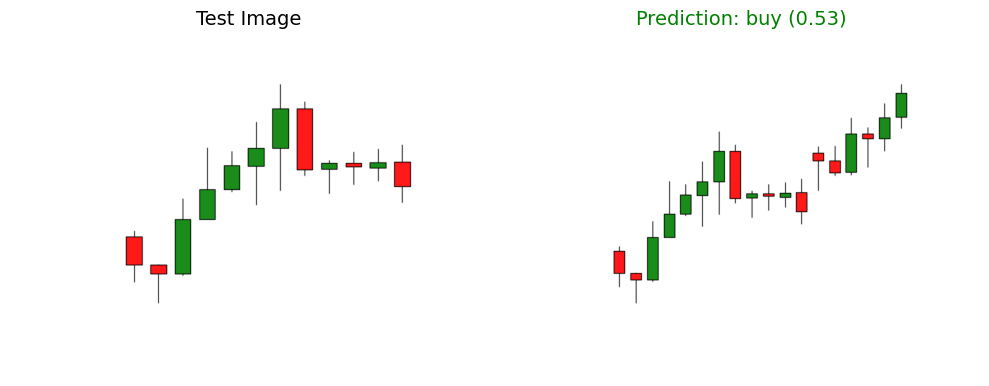

In [16]:
test_image_base_path = '/content/output_folder/test'
candlestick_charts_path = '/content/output_latest_data.zip/candlestick_charts'
# Load class mappings
id2label = model.config.id2label
label2id = model.config.label2id
# Call the visualization function
visualize_prediction(threshold=0.0)

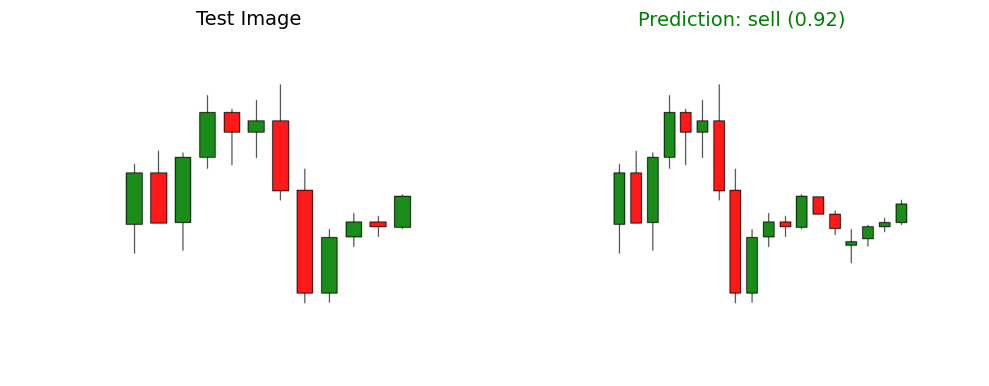

In [17]:
# Call the visualization function
visualize_prediction(threshold=0.90)

## Downloading the EURUSD data for predictions

In [21]:
def download_and_extract_data_predictions(filename="output_latest", filename_output="output"):
  """
  Downloads, extracts, and deletes a zip file if it doesn't already exist.

  Args:
      filename: The name of the zip file to download.
      filename_output: The name of the folder to extract the contents to.
  """
  if not os.path.exists(filename_output):
      try:
          # Download the .zip file
          print(f"Downloading '{filename}'...")
          # Get the actual downloaded file path
          downloaded_file_path = kagglehub.dataset_download("sulimantadros/buy-sell-object-detection-dataset-eurusd")

          # Rename if necessary (if kagglehub returns a different name)
          if downloaded_file_path != filename:
              os.rename(downloaded_file_path, filename)
              print(f"Renamed downloaded file to '{filename}'")

      except Exception as e:
          print(f"An error occurred: {e}")
  else:
      print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data_predictions(filename="output_latest_data_EURUSD_1.zip", filename_output="output")

100%|██████████| 44.3M/44.3M [00:00<00:00, 168MB/s]

Extracting files...


Renamed downloaded file to 'output_latest_data_EURUSD_1.zip'


In [29]:
# Define the configuration for the model
config = AutoConfig.from_pretrained(
    model_name,  # Use the base configuration from a pre-trained model
    num_labels=2,  # Number of classes
    id2label={0: "buy", 1: "sell"},
    label2id={"buy": 0, "sell": 1}
)

# Load the model with the defined configuration
model = AutoModelForImageClassification.from_config(config)

# Load the weights from the `safetensors` file
weights = load_file("/content/output_latest_model.zip/saved_model_1_no_threshold_based_model_64%/model.safetensors")
model.load_state_dict(weights)

image_processor = AutoImageProcessor.from_pretrained(model_name)

# Define the base directory
base_dir = "/content/output_latest_data_EURUSD_1.zip/EURUSD"

# Dictionary to store results
predictions_dict = {}

# Get the total number of sequence folders
total_folders = sum([len(dirs) for _, dirs, _ in os.walk(base_dir)])
completed_folders = 0

# Loop through each sequence folder and process the `historical_chart.png`
for root, dirs, files in os.walk(base_dir):
    for dir_name in dirs:
        sequence_folder = os.path.join(root, dir_name)
        historical_chart_path = os.path.join(sequence_folder, "historical_chart.png")

        if os.path.exists(historical_chart_path):
            # Get the prediction for the historical chart
            predicted_class, confidence = predict_image(historical_chart_path, model, image_processor)

            # Store the result in the dictionary
            predictions_dict[sequence_folder] = {
                "predicted_class": predicted_class,
                "confidence": confidence,
            }
        else:
            print(f"Missing historical_chart.png in {sequence_folder}")

        # Update the progress counter
        completed_folders += 1
        progress_message = f"Progress: {completed_folders}/{total_folders} folders completed"
        sys.stdout.write(f"\r{progress_message}")
        sys.stdout.flush()

print("\nProcessing complete!")

# Define the path to save the CSV file
output_csv_path = "/content/predictions_results.csv"

# Save the results to a CSV file
with open(output_csv_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write the header
    csv_writer.writerow(["Folder", "Predicted Class", "Confidence"])

    # Write the prediction results
    for folder, result in predictions_dict.items():
        csv_writer.writerow([folder, result["predicted_class"], result["confidence"]])

print(f"Results saved to {output_csv_path}")

Progress: 5718/5718 folders completed
Processing complete!
Results saved to /content/predictions_results.csv


In [30]:
# Define the path to the CSV file and threshold
input_csv_path = "/content/predictions_results.csv"
output_filtered_csv_path = "/content/filtered_predictions_results.csv"
threshold = 0.9

# Read the CSV file into a DataFrame
df = pd.read_csv(input_csv_path)

# Filter rows where the Confidence column is above the threshold
filtered_df = df[df['Confidence'] > threshold]

print(f"Number of rows above threshold ({threshold}): {len(filtered_df)}")

Number of rows above threshold (0.9): 473


In [35]:
# Create a copy of the DataFrame to avoid the warning
filtered_df = filtered_df.copy()

# Extract the sequence number from the Folder column
filtered_df['Sequence_Number'] = filtered_df['Folder'].str.extract(r'sequence_(\d+)').astype(int)

# Sort the DataFrame by the extracted Sequence_Number
sorted_df = filtered_df.sort_values(by='Sequence_Number')

# Drop the auxiliary Sequence_Number column (optional)
sorted_df = sorted_df.drop(columns=['Sequence_Number'])

# Save the sorted DataFrame to a new CSV file
sorted_output_csv_path = "/content/sorted_filtered_predictions_results.csv"
sorted_df.to_csv(sorted_output_csv_path, index=False)

print(f"Sorted results saved to {sorted_output_csv_path}")

Sorted results saved to /content/sorted_filtered_predictions_results.csv


Results saved to /content/trade_results.csv


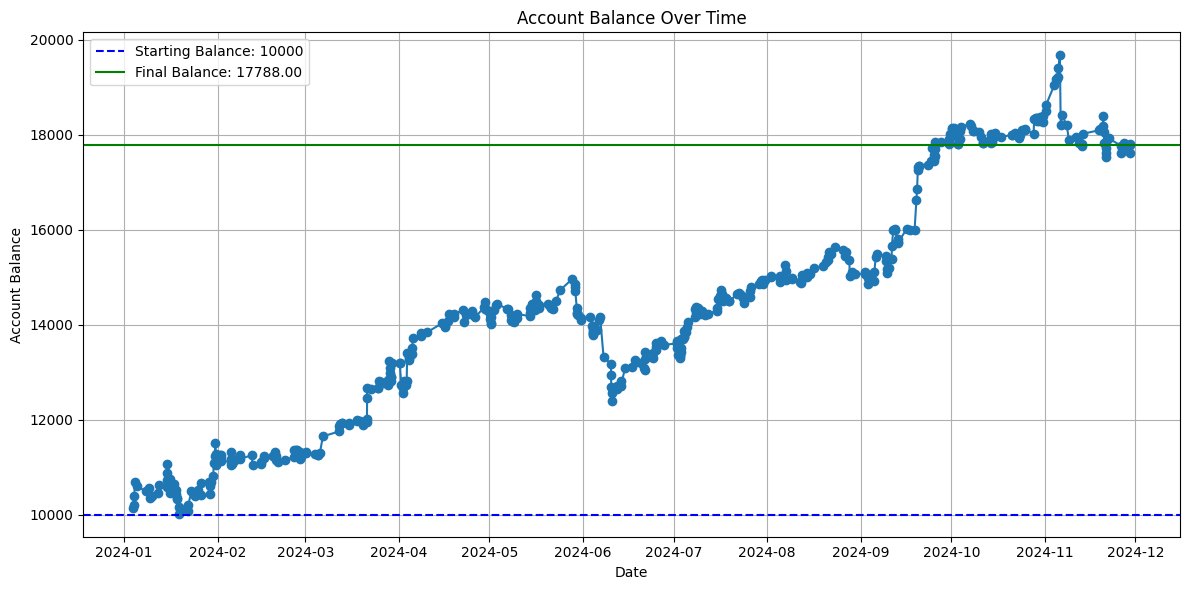

Final Balance: 17788.00


In [96]:
# Define parameters
starting_balance = 10000
balance = starting_balance
lot_size = 100000  # Lot size (can be adjusted)
profits = []  # To track account balance over time
dates = []  # To track trade dates
predicted_labels = []  # To track predicted labels
predictions_bool_list = []
actual_labels = []
folders = []

# Define ID-to-label mapping
id2label = {0: "buy", 1: "sell"}

# Iterate over sorted folder paths in the sorted DataFrame
for folder in sorted_df['Folder']:
  # Define paths to historical and future data CSVs
  historical_csv_path = os.path.join(folder, "historical_data.csv")
  future_csv_path = os.path.join(folder, "future_data.csv")

  # Check if both files exist
  if not os.path.exists(historical_csv_path) or not os.path.exists(future_csv_path):
      print(f"Missing data files in folder: {folder}")
      continue

  # Read in the CSV files
  historical_data = pd.read_csv(historical_csv_path)
  future_data = pd.read_csv(future_csv_path)

  # Get the last close price from historical and future data
  historical_last_close = historical_data['close'].iloc[-1]
  future_last_close = future_data['close'].iloc[-1]

  # Get the predicted class and confidence from the sorted DataFrame
  predicted_class = sorted_df.loc[sorted_df['Folder'] == folder, 'Predicted Class'].values[0]
  predicted_label = id2label[predicted_class]  # Convert to human-readable label

  folder_path = sorted_df.loc[sorted_df['Folder'] == folder, 'Folder'].values[0]

  # Calculate profit or loss based on the predicted action
  if predicted_label == "buy":
      profit = (future_last_close - historical_last_close) * lot_size  # Profit for buy
  elif predicted_label == "sell":
      profit = (historical_last_close - future_last_close) * lot_size  # Profit for sell
  else:
      continue  # Skip if no valid prediction

  if (predicted_label == "buy") and (future_last_close > historical_last_close):
    predictions_bool_list.append(True)
  elif (predicted_label == "sell") and (future_last_close < historical_last_close):
    predictions_bool_list.append(True)
  else:
    predictions_bool_list.append(False)

  if future_last_close > historical_last_close:
    actual_labels.append("buy")
  elif future_last_close < historical_last_close:
    actual_labels.append("sell")

  folders.append(folder_path)

  # Update the balance
  balance += profit
  profits.append(balance)  # Track the account balance over time

  # Track the date (use the last date from historical data)
  trade_date = future_data['time'].iloc[-1]
  dates.append(trade_date)

  predicted_labels.append(predicted_label)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    "Date": dates,
    "Account Balance": profits,
    "Predicted Label": predicted_labels,
    "actual_labels": actual_labels,
    "folders": folders,
    "predictions_bool_list": predictions_bool_list
})

# Save the results to a CSV file
results_csv_path = "/content/trade_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

# Plot the account balance over time
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(results_df["Date"]), results_df["Account Balance"], marker='o', linestyle='-')
plt.title("Account Balance Over Time")
plt.xlabel("Date")
plt.ylabel("Account Balance")
plt.axhline(starting_balance, color='blue', linestyle='--', label=f'Starting Balance: {starting_balance}')
plt.axhline(balance, color='green', linestyle='-', label=f'Final Balance: {balance:.2f}')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig("/content/account_balance_plot.png")  # Save the plot as an image
plt.show()

# Print the final balance
print(f"Final Balance: {balance:.2f}")

In [106]:
csv_path = "/content/trade_results.csv"
# Read the CSV and extract the folder paths
df = pd.read_csv(csv_path)

# Count the number of True and False values
true_count = df['predictions_bool_list'].sum()  # True values are equivalent to 1
false_count = len(df['predictions_bool_list']) - true_count  # Total minus True values

# Calculate accuracy percentage
accuracy = (true_count / len(df['predictions_bool_list'])) * 100

# Print the results
print(f"True count: {true_count}")
print(f"False count: {false_count}")
print(f"Accuracy: {accuracy:.2f}%")

True count: 259
False count: 214
Accuracy: 54.76%


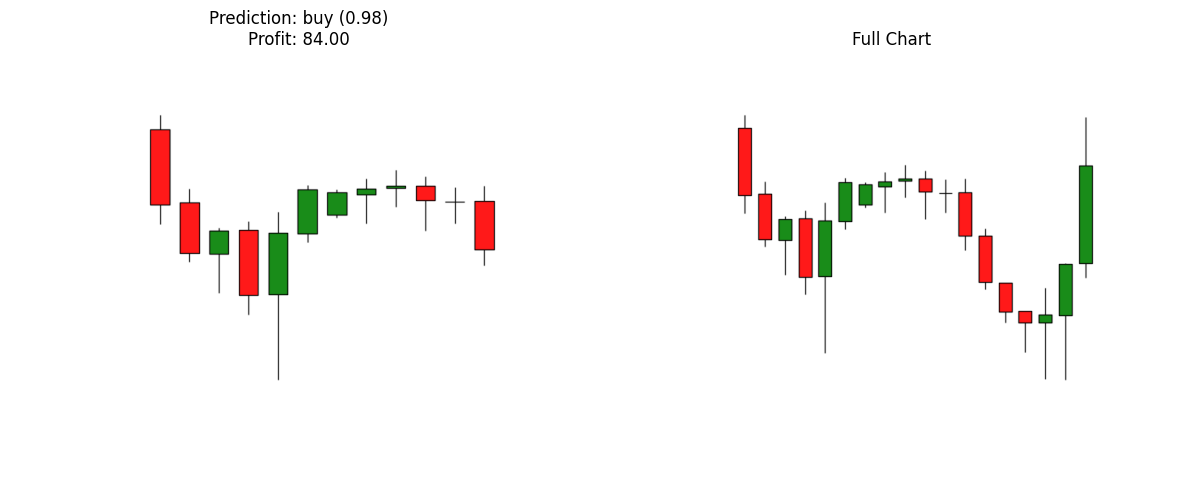

In [113]:
# Example usage
base_dir = "/content/output_latest_data_EURUSD_1.zip/EURUSD"
csv_path = "/content/sorted_filtered_predictions_results.csv"
#folder_path = '/content/output_latest_data_EURUSD_1.zip/EURUSD/EURUSD_sequence_37'  # Set to a specific folder path or leave as None for random selection
folder_path = None
visualize_sequence(base_dir, model, image_processor, id2label, csv_path, folder_path)